In [1]:
import sys
import os

import numpy as np
from __future__ import division

# ===============
# ORGANIZE FOLDERS
# ===============
home_path = os.path.expanduser('~')
analysis_path = home_path + '/Documents/Kaggle/Whats_Cooking/notebooks/'
sys.path.append(analysis_path)

# input data folder
input_path = home_path + '/Documents/Kaggle/Whats_Cooking/input_data/'

In [2]:
import pandas as pd

# ==============
# LOAD DATA
# ==============
file_name = 'train.json'
input_data = input_path + file_name

data_frame = pd.read_json(input_data)

# First look at the dataset

In [3]:
data_frame.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


The dataset looks pretty organized in a first view. All the ingredients of each recipe are entries of a list, but we still don't know if we can encounter typos or special characters between them.

# Recipes

In [4]:
n_recipes = data_frame.shape[0]
print('This dataset has %i recipes.' % n_recipes)

This dataset has 39774 recipes.


# Cuisines

Let's check what cuisines are present in the dataset.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.5)

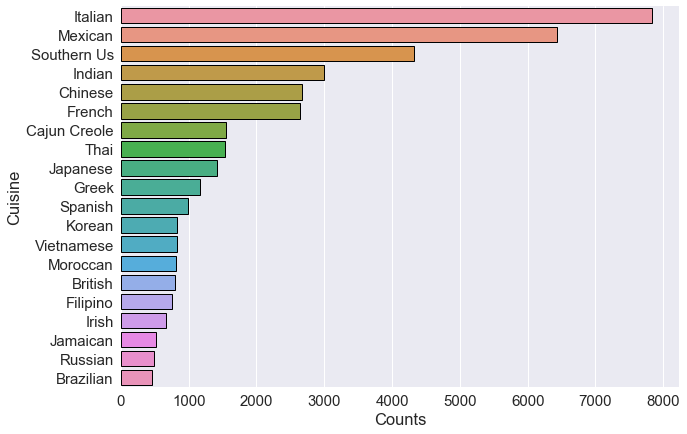

In [6]:
cuisine = data_frame['cuisine'].value_counts()
cuisine_names = list(cuisine.index)
cuisine_values = list(cuisine.values)

# string manipulation of cuisine names
for i, name in enumerate(cuisine_names):
    capital_name = name.title() # capitalize each word
    cuisine_names[i] = capital_name
    
    if capital_name.find('_') > 0: # found an underscore in the string name
        clean_name = capital_name.replace('_', ' ') # replace it with a space
        cuisine_names[i] = clean_name

plt.figure(figsize=(10,7))
sns.barplot(x=cuisine_values, y=cuisine_names, edgecolor=(0,0,0), linewidth=1)
plt.ylabel('Cuisine')
plt.xlabel('Counts')
plt.show()

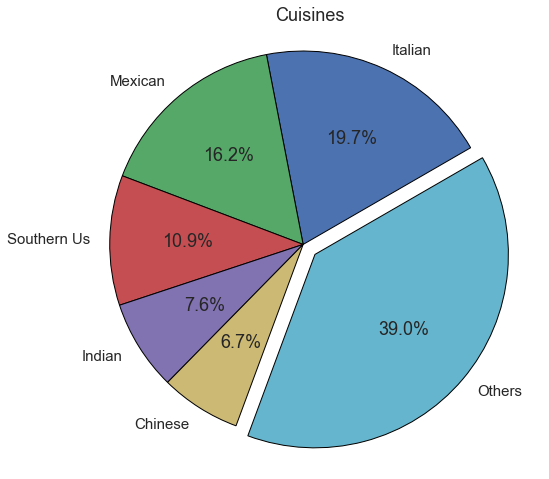

In [7]:
top_cuisines = 5
short_cuisine_values = cuisine_values[0:top_cuisines]
short_cuisine_values.append(sum(cuisine_values[top_cuisines:]))
short_cuisine_names = cuisine_names[0:top_cuisines]
short_cuisine_names.append(u'Others')

# making a pie plot
plt.figure(figsize=(7,7))

# explode the last slice ('Others')
explode = list(np.zeros(top_cuisines))
explode.append(0.08)

# edges properties
wedgeprops={"edgecolor":"k", 'linewidth': 1}

plt.pie(short_cuisine_values, labels=short_cuisine_names, startangle=30,  
        autopct='%1.1f%%', explode=explode, wedgeprops=wedgeprops)
plt.title('Cuisines')
plt.tight_layout()
plt.axis('equal')
plt.show()

In [8]:
n_cuisines = cuisine.nunique()
print('This dataset has %i different cuisines.' % n_cuisines)

This dataset has 20 different cuisines.


As we can see in the previous plots, **Italian** and **Mexican** cuisines represent a bigger part of the entire dataset. We will have to keep in mind that this effect could introduce a bias in our learning model.

# Ingredients 
Now let's check the average amount of ingredients of each cuisine. 

In [9]:
# adding a new column with the amount of ingredients for each recipe
data_frame['n_ingredients'] = data_frame['ingredients'].str.len()
data_frame.head()

,cuisine,id,ingredients,n_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20


In [10]:
# using 'groupby' method to calculate the mean and standard deviation of 
# total number of ingredients per cuisine
mean_ingredients = data_frame.groupby(['cuisine'])['n_ingredients'].mean()
std_ingredients = data_frame.groupby(['cuisine'])['n_ingredients'].std()

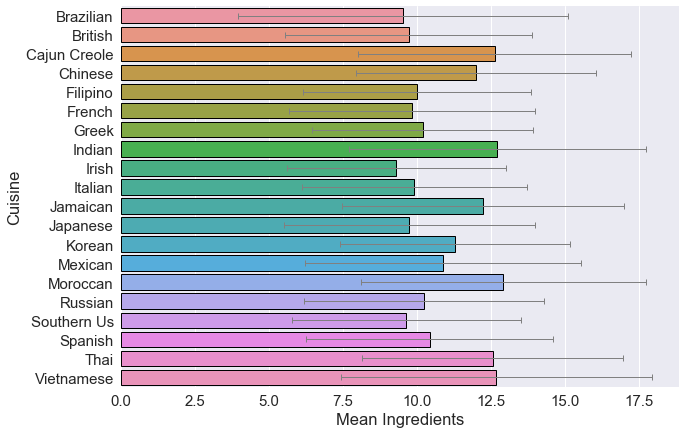

In [11]:
# string manipulation of cuisine names
cuisine_names = []

for name in mean_ingredients.index:
    name = name.title() # capitalize each word
    
    if name.find('_') > 0: # found an underscore in the string name
        name = name.replace('_', ' ') # replace it with a space
    cuisine_names.append(name)

plt.figure(figsize=(10,7))
sns.barplot(x=mean_ingredients.values, xerr=std_ingredients.values, 
            y=cuisine_names, edgecolor=(0,0,0), linewidth=1,
            error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
plt.ylabel('Cuisine')
plt.xlabel('Mean Ingredients')
plt.show()

It looks like every cuisine has on average the same ammount of ingredients within the error bars. There is no big discrepancy among them.

Now let's have a look on the most used ingredients in the total dataset.

In [12]:
from collections import Counter
from multiprocessing import Pool, cpu_count

def parallel_counting(data):
    """
    Auxiliary function for parallel counting.
    """
    return data.map(Counter).sum()

def ingredients_counter(data):
    """
    Function to count the ingredients in parallel fashion.
    
    Parameter:
    ---------
    data : pandas series
        Pandas Series object with the ingredients for counting.
        
    Returns:
    -------
    ingredients_count : pandas series
        Series with count for each ingredient.
        
    Note:
    ----
    The ingredients are returned in descending order
    """
    # Let's make this counter process parallel 
    # using the 'multiprocessing' library
    cores = cpu_count()

    # separate data into chunks for the parallel processing
    data_chunks = np.array_split(data, cores)
    
    pool = Pool(cores)
    counter_list = pool.map(parallel_counting, data_chunks)
    pool.close()

    ingredients_count = pd.Series(sum(counter_list, Counter())).sort_values(ascending=False)
    return ingredients_count

# Counting ingredients from the entire dataset
ingredients_count = ingredients_counter(data_frame['ingredients'])

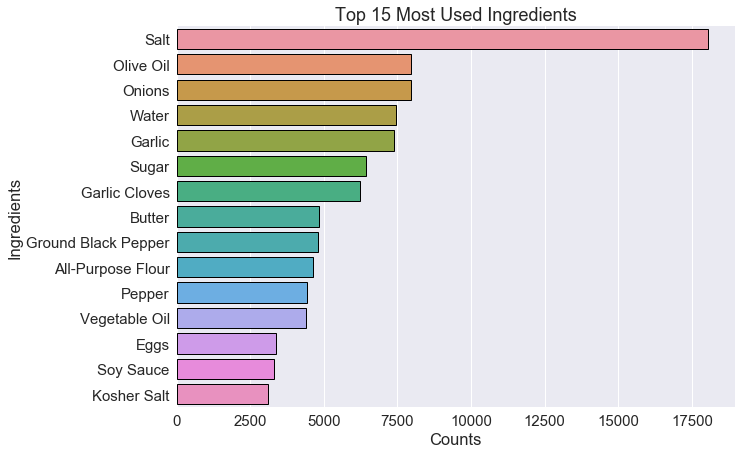

In [13]:
# Getting the top ingredients in the whole dataset
top_common = 15
top_ingredients_names = list(ingredients_count[:top_common].index)
top_ingredients_values = list(ingredients_count[:top_common].values)

# string manipulation of cuisine names
clean_names = []
for i, name in enumerate(top_ingredients_names):
    name = name.title() # capitalize each word
    
    if name.find('_') > 0: # found an underscore in the string name
        name = name.replace('_', ' ') # replace it with a space
    clean_names.append(name)

plt.figure(figsize=(10,7))
sns.barplot(x=top_ingredients_values, y=clean_names, edgecolor=(0,0,0), linewidth=1)
plt.ylabel('Ingredients')
plt.xlabel('Counts')
plt.title('Top %i Most Used Ingredients' % int(top_common))
plt.show()

## Comparing ingredients of different cuisines

In this section we will make a **Radar Plot** to compare how much the **Italian** and **Mexican** cuisines use the top ingredients of the entire dataset.

In [14]:
def cuisine_ingredients(data_frame, cuisine_name):
    """
    This function gets the specific ingredients for a particular cuisine.
    
    Parameters:
    ----------
    data_frame : pandas dataframe
        The original dataset.
    cuisine_name : str
        Cuisine name as written in the original dataset.
            - mexican
            - italian
            - cajun_creole ...
            
    Returns:
    -------
    data : pandas series
        Pandas Series with the ingredients for the specific cuisine.
    """
    data = data_frame['ingredients'][data_frame['cuisine']==cuisine_name]
    return pd.Series(data)

In [15]:
from math import pi

def ingredients_radar_plot(data1, data2, cuisine_names, ingredients_names):
    """
    Function to create and plot a radar graph comparing
    ingredients of two different cuisines.
    
    Parameters:
    ----------
    data1 : pandas series
        Series with the ingredients of the first cuisine.
    data2 : pandas series
        Series with the ingredients of the seocnd cuisine.
    cuisine_names : list
        List cotainig the names of each cuisine ti comparison.
    ingredients_names : list
        List containing the names of teh ingredients that one 
        would like to compare.
        
    Returns:
    -------
    Radar Plot on Screen.
    
    Note:
    ----
    The qunatity of ingredients is normalized 
    """
    # string manipulation of cuisine names
    clean_names = []
    for i, name in enumerate(ingredients_names):
        name = name.title() # capitalize each word
    
        if name.find('_') > 0: # found an underscore in the string name
            name = name.replace('_', ' ') # replace it with a space
        clean_names.append(name)
    
    # PART 1: Create Background
    N = len(ingredients_names)
    
    # What will be the angle of each axis in the plot? 
    # R: plot / number of variables.
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles.append(angles[0]) # We need to repeat the first values 
                             # to close the circular graph
        
    # Initialise the spider plot
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable + add labels yet
    plt.xticks(angles[:-1], clean_names)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(color="grey", size=13)
    
    # PART 2: Add plots
    # Ind1
    values = list(data1[ingredients_names] / sum(data1[ingredients_names]))
    values.append(values[0])
    ax.plot(angles, values, linewidth=1, linestyle='solid', 
            label=cuisine_names[0], color='b')
    ax.fill(angles, values, 'b', alpha=0.1)
 
    # Ind2
    values = list(data2[ingredients_names] / sum(data2[ingredients_names]))
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', 
            label=cuisine_names[1], color='r')
    ax.fill(angles, values, 'r', alpha=0.1)
 
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    plt.show()

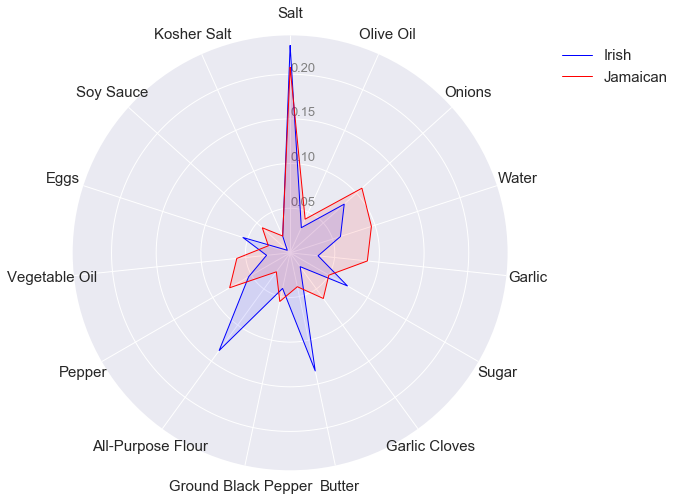

In [16]:
# Selecting ingredients from two different cuisines
cuisine_names = ['Irish', 'Jamaican']

cuisine1_ingredients = cuisine_ingredients(data_frame, cuisine_names[0].lower())
cuisine2_ingredients = cuisine_ingredients(data_frame, cuisine_names[1].lower())

# Counting ingredients from Mexican and Italian cuisines
cuisine1_ingredients_count = ingredients_counter(cuisine1_ingredients)
cuisine2_ingredients_count = ingredients_counter(cuisine2_ingredients)

ingredients_radar_plot(cuisine1_ingredients_count, cuisine2_ingredients_count, 
                       cuisine_names, top_ingredients_names)

# Text Analysis

Now let's have a closer look at the strings that compose the list of ingredients of each recipe. We can see from previous plots that we have the same ingredient presented in diffrent forms or variations in each recipe. 

Example:
* Garlic = Garlic Cloves
* Tomatoes = Diced Tomatoes
* Ground Black Pepper = Black Pepper

In [17]:
regex = (r'\btomatoes\b')


a = ingredients_count.index[ingredients_count.index.str.contains(r'\btomato\b')]
ingredients_count[a].head(50)

tomato paste                                              1158
tomato sauce                                               865
tomato purée                                               217
tomato juice                                                83
tomato ketchup                                              69
tomato salsa                                                45
tomato basil sauce                                          23
condensed tomato soup                                       17
fresh tomato salsa                                          13
(    oz.) tomato sauce                                      11
tomato soup                                                 11
sundried tomato pesto                                       10
(   oz.) tomato paste                                        9
organic tomato                                               7
yellow tomato                                                7
sundried tomato paste                                  

In [18]:
a = list(ingredients_count.index[ingredients_count.index.str.contains(u'[©|™|®]')])
ingredients_count[a].head()

Country Crock® Spread                       21
I Can't Believe It's Not Butter!® Spread    18
Bertolli® Classico Olive Oil                16
Old El Paso™ chopped green chiles           12
Old El Paso™ taco seasoning mix             11
dtype: int64

In [19]:
a = list(ingredients_count.index[ingredients_count.index.str.contains(u'at')])
ingredients_count[a].head()

water                     7457
tomatoes                  3058
grated parmesan cheese    1886
diced tomatoes            1624
tomato paste              1158
dtype: int64